# GPPM with dynamical systems

This tutorial introduces the use of the software GPMM-DS available at https://gitlab.inria.fr/epione/GP_progression_model_V2.git@feature/propagation_models



## Objectives : 

- Discover a framework for investigation of bio–mechanical hypotheses governing disease progression 

- Check out how you can model amyloid dynamics over the brain connectome in ADNI data 


## Installation

In [ ]:
!pip install git+https://gitlab.inria.fr/epione/GP_progression_model_V2.git@feature/propagation_models

  Cloning https://gitlab.inria.fr/epione/GP_progression_model_V2.git (to revision feature/propagation_models) to /tmp/pip-req-build-39trl1ns
  Running command git clone -q https://gitlab.inria.fr/epione/GP_progression_model_V2.git /tmp/pip-req-build-39trl1ns
  Running command git checkout -b feature/propagation_models --track origin/feature/propagation_models
  Switched to a new branch 'feature/propagation_models'
  Branch 'feature/propagation_models' set up to track remote branch 'feature/propagation_models' from 'origin'.
  Created wheel for gppm: filename=gppm-2.0.0-cp37-none-any.whl size=24901 sha256=a711ee26a1340b4a36bc4247c08c3bda7ae4abb0c1dc5d2a24629b86f2e378f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-c1c5g00e/wheels/8c/91/62/cecf21f30ab2cf21b105503711aa416a6f3acd40de119ac09f
Successfully built gppm


In [ ]:
# We now import what is needed to run this tutorial

import GP_progression_model

import numpy as np
import matplotlib
#%matplotlib inline
from sys import platform as sys_pf
if sys_pf == 'darwin':
    matplotlib.use("TkAgg")
import GP_progression_model
from GP_progression_model import DataGenerator
import matplotlib.pyplot as plt
import torch

## Part I: introducing the framework

### GPPM-basic
In the previous session, we have learnt about the GPPM framework for estimating long term biomarker trajectories ${\bf f}$, together with individual time-reparametrization parameters $\tau^s$, from short-term data ${\bf Y}^s$:

$$
 {\bf Y}^s(\tau^s) = {\bf f}(\tau^s) + {\boldsymbol \nu}^s(\tau^s) +\epsilon.
$$

Now, we know that we need to impose **monotonicity constraints** in order to identify the biomarker trajectories. 

### GPPM-DS
But what if we use more complex constraints, for example requiring that the trajectories are constrained to some **dynamical systems** describing possible undergoing biological processes?


#### An example

Let's imagine a situation in which we have three biomarkers (it's easier if we think of them as, for instance, amyloid in three different brain regions): A, B and C.


![3biomarkers](https://github.com/Disease-Progression-Modelling/disease-progression-modelling.github.io/blob/master/_static/img/gppm/notebook-figs/note0.png?raw=true)


We can then hypothesize the existence of different underlying biological processes that rule how the biomarkers' values evolve over time. 

For instance: all the biomarkers communicate with one-another, and so their values, over time, vary according to how much they receive/release to the other biomarkers.

![3biomarkers-connected](https://github.com/Disease-Progression-Modelling/disease-progression-modelling.github.io/blob/master/_static/img/gppm/notebook-figs/note1.png?raw=true)

Or just A and B could be interconnected:

![3biomarkers-partiallyconnected](https://github.com/Disease-Progression-Modelling/disease-progression-modelling.github.io/blob/master/_static/img/gppm/notebook-figs/note2.png?raw=true)

and so on. 

#### Formally...

We can formalise the existence of such processes through **dynamical systems** modelling:

$$ {\bf{\dot{f}}}(t) = \mathcal{H}_{\boldsymbol\theta}(\bf{f}(t), t)$$

Here ${\bf f}$ represents the array of biomarkers $(A, B, C)$, while $\mathcal{H}_{\boldsymbol\theta}$ encodes the information regarding:
- the kind of process going on (i.e. the biomarkers simply diffuse over time? Or do they also plateau/saturate etc etc?) 
- the connections between biomarkers.


*Of course in a real-case scenario we do not know $\mathcal{H}_{\boldsymbol\theta}$, and instead we are interested in providing estimates of it!*



Well, using the GPPM, we can set-up a **combined framework** to investigate the different bio–mechanical hypotheses governing disease progression.

In order to do so, we equip the standard GPPM model 

\begin{equation}
 {\bf Y}^s(\tau^s) = {\bf f}(\tau^s) + {\boldsymbol \nu}^s(\tau^s) +\epsilon,
\end{equation}

with (unknown) dynamical systems constraints on the biomarker trajectories

\begin{equation}
{\bf\dot{f}}(t) = \mathcal{H}_{\boldsymbol\theta}({\bf f}(t), t).
\end{equation}



**The combined GPPM-DS framework provides spatio–temporal modeling and inference of biomarkers dynamics from short term data.**

This means we can estimate:
- long term biomarker trajectories ${\bf f}$;
- individual time-reparametrization parameters $g^s(\tau)$,
- dynamical system parameters $\theta$ (they depend on the chosen DS).




## Part II: experimenting with different dynamical systems

### Diffusion data with different connections between biomarkers

Let's check how the framework can be used to generate data with different underlying biological processes

In [ ]:
### Forward modelling.

# Definition of propagation model

propagation_model = "diffusion" # here we define which propagation model we use. Let's stick to "diffusion" for now

Here we use the "diffusion" propagation model of equation
$${\bf\dot f}(t) = K_{{\bf\theta}_D}{\bf f}(t),$$
where the matrix $K_{{\bf\theta}_D}$ encodes region--wise, constant rates of protein propagation across connected regions.

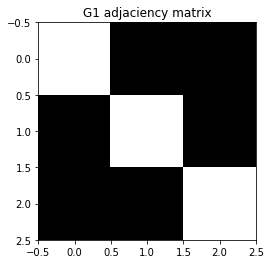

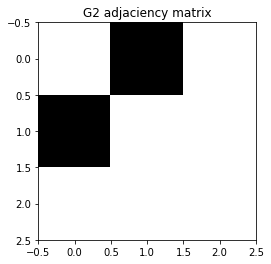

In [ ]:
Nbiom = 3 # number of biomarkers
interval = [0, 8] # lenght of the temporal interval
Nsubs = 10 # number of subjects

names_biomarkers = [str(i) for i in [j for j in range(1, Nbiom+1)]]
N_kij_parameters = int((int(Nbiom * Nbiom) - int(Nbiom)) / 2) # Numbers of parameters
N_tot_parameters = N_kij_parameters

# Let's define also the structure of connections. It can be seen as the adjaciency matrix of a graph

G1 = np.array([[0,1,1],[1,0,1],[1,1,0]]) # A <-> B <-> C
G2 = np.array([[0,1,0],[1,0,0],[0,0,0]]) # A <-> B ; C

plt.figure()
plt.title('G1 adjaciency matrix')
plt.imshow(G1, cmap='Greys', interpolation='none')

plt.figure()
plt.title('G2 adjaciency matrix')
plt.imshow(G2, cmap='Greys', interpolation='none')

In [ ]:
theta_kij =  np.array([0.3, 0.2, 0.5]) ## Propagation parameters between regions

x0 = np.array([0.1, 0.6, 0.8]).reshape(Nbiom, 1) ## x0 - initial point (baseline values)

theta_vec = (theta_kij)

[5, 6, 7, 8, 9, 10, 11, 12]
[5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8]


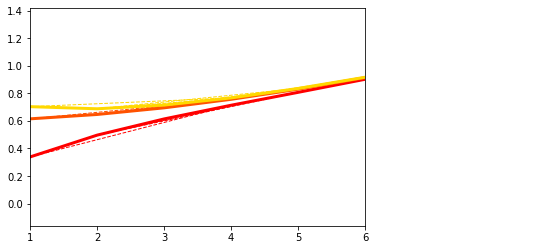

In [ ]:
## Generate data 1 and plot 
theta1 = (theta_vec, 3., 3., N_tot_parameters, G1, x0, 0)
dg1 = DataGenerator.DataGenerator(Nbiom, interval, theta1, Nsubs, propagation_model)

plt.figure()
dg1.plot(mode=1, save_fig = False)

[5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8]
[7, 8, 9, 10, 11, 12, 13, 14]


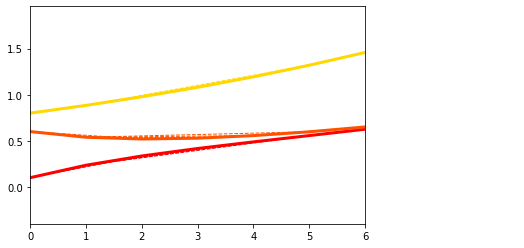

In [ ]:
## Generate data 2 and plot 
theta2 = (theta_vec, 3., 3., N_tot_parameters, G2, x0, 0)
dg2 = DataGenerator.DataGenerator(Nbiom, interval, theta2, Nsubs, propagation_model)

plt.figure()
dg2.plot(mode=1, save_fig = False)

### Changing number of markers, propagation parameters, etc

We can now play with the various parameters and see how the model behaves!

In [ ]:
Nbiom = 5 # number of biomarkers - you can change it HERE
    
names_biomarkers = [str(i) for i in [j for j in range(1, Nbiom+1)]]
N_kij_parameters = int((int(Nbiom * Nbiom) - int(Nbiom)) / 2) # Numbers of parameters
N_tot_parameters = N_kij_parameters

# Generate random matrix G for diffusion between regions
G = DataGenerator.GenerateConnectome(Nbiom)
while np.max(np.max(G)) == 0:
    G = DataGenerator.GenerateConnectome(Nbiom)

## Random propagation parameters between regions --> try varying the interval to [0, .1] HERE
theta_kij =  np.random.uniform(0, .5, N_tot_parameters) 

x0 = np.array(np.random.uniform(0, .5, Nbiom, )).reshape(Nbiom, 1) # Random x0 - initial point (baseline values)

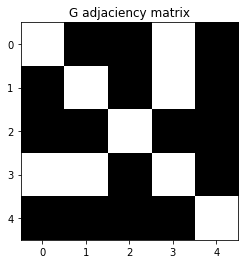

In [ ]:
## Plot the structure of the biomarkers' connections (adjaciency matrix)

plt.figure()
plt.title('G adjaciency matrix')
plt.imshow(G, cmap='Greys', interpolation='none')

[2, 3, 4, 5, 6, 7, 8, 9]
[3, 4, 5, 6, 7, 8, 9, 10]
[6, 7, 8, 9, 10, 11, 12, 13]
[3, 4, 5, 6, 7, 8, 9, 10]
[5, 6, 7, 8, 9, 10, 11, 12]


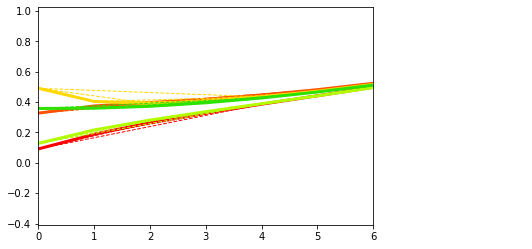

In [ ]:
## Generate the data 
theta_vec = (theta_kij)
theta = (theta_vec, 3., 3., N_tot_parameters, G, x0, 0)
dg = DataGenerator.DataGenerator(Nbiom, interval, theta, Nsubs, propagation_model)

## And plot 
plt.figure()
dg.plot(mode=1, save_fig = False)

### Changing the dynamical system

We have different propagation models we can 
We have implemented the **Reaction-diffusion (RD)** model:

$${\bf \dot f}(t) = K_{{\theta}_{RD}} {\bf f}(t) + R_{{\theta}_{RD}}{\bf f}(t)({\upsilon} - {\bf f}(t)).$$


This model includes a propagation and an aggregation mechanism and is comprised of two terms: a diffusion term for constant protein propagation and a reaction term for protein aggregation. This term eventually reaches a plateau when protein concentration get to a maximal concentration threshold $\upsilon$. 

And the **Accumulation-Clearance-Propagation (ACP)** model:

$${\bf\dot f}(t) 
  = K_{{\theta}_{ACP}}({\bf f},t) {\bf f}(t)+ R_{{\theta}_{ACP}}({\bf f},t){\bf f}(t)$$

The ACP model describes the three processes of accumulation, clearance and propagation of proteins allowing for non--constant effects. 
The propagation term $K_{{\theta}_{ACP}}$ is concentration--dependent: the toxic protein concentration in each region saturates when reaching a first critical threshold $\gamma=(\gamma_1,...,\gamma_N)$, and subsequently triggers propagation towards the connected regions. Propagation also reaches a plateaus when passing a second critical threshold $\eta=(\eta_1,...,\eta_N)$. 




[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


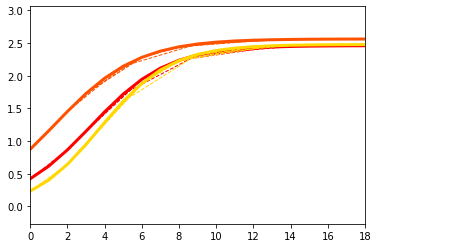

In [ ]:
######### We can now experiment with the three propagation models: try changing
# - propagation_model
# - Nbiom
# - the various thresholds/propagation parameters:
#         * diffusion: theta_kij
#         * RD: upsilon_main, theta_kij
#         * ACP: gamma_main, eta_main, theta_kij


# propagation_model = "diffusion"
#propagation_model = "ACP"
propagation_model = "reaction-diffusion"

Nbiom = 3
interval = [0, 20]
Nsubs = 50
names_biomarkers = [str(i) for i in [j for j in range(1, Nbiom + 1)]]

G = DataGenerator.GenerateConnectome(Nbiom)
while np.max(np.max(G)) == 0:
    G = DataGenerator.GenerateConnectome(Nbiom)

if propagation_model == "ACP":

    ## Numbers of parameters
    N_thres_parameters = 2 * Nbiom
    N_kt_parameters = 1
    N_kij_parameters = int((int(Nbiom * Nbiom) - int(Nbiom)) / 2)
    N_tot_parameters = N_kij_parameters + N_kt_parameters + N_thres_parameters

    gamma_main = 0.6 # Saturation and plateau regional thresholds: gamma and eta. Initialised as small variations around two main values
    eta_main = 0.9

    gamma = gamma_main + 0.2 * np.array(np.random.uniform(-1, 1, int(N_thres_parameters / 2), )).reshape(
        int(N_thres_parameters / 2), 1)
    eta = eta_main + + 0.2 * np.array(np.random.uniform(-1, 1, int(N_thres_parameters / 2), )).reshape(
        int(N_thres_parameters / 2), 1)

    theta_kij = np.random.uniform(0, .1, N_kij_parameters) # Propagation parameters between regions
    
    kt = 0.2 # Initial trigger
  
    x0 = np.array(np.random.uniform(0, 1, Nbiom, )).reshape(Nbiom, 1) # x0 - initial point for generation
    theta_vec = (theta_kij, kt, eta, eta - gamma)
    theta = (theta_vec, 3., 3., N_tot_parameters, G, x0, 0)

elif propagation_model == 'diffusion':
    ## Numbers of parameters
    N_kij_parameters = int((int(Nbiom * Nbiom) - int(Nbiom)) / 2)
    N_tot_parameters = N_kij_parameters

    theta_kij = np.random.uniform(0, .05, N_tot_parameters) # Propagation parameters between regions

    x0 = np.array(np.random.uniform(0, 1, Nbiom, )).reshape(Nbiom, 1) # x0 - initial point for generation
    theta_vec = (theta_kij)
    theta = (theta_vec, 3., 3., N_tot_parameters, G, x0, 0)

elif propagation_model == 'reaction-diffusion':
    ## Numbers of parameters
    N_thres_parameters = Nbiom
    N_kt_parameters = 1
    N_kij_parameters = int((int(Nbiom * Nbiom) - int(Nbiom)) / 2)
    N_tot_parameters = N_kij_parameters + N_kt_parameters + N_thres_parameters

    upsilon_main = 2 # Plateau regional threshold: upsilon. Initialised as small variations around one main value
    upsilon = upsilon_main + 0.2 * np.array(np.random.uniform(-1, 1, int(N_thres_parameters), )).reshape(
        int(N_thres_parameters), 1)

    theta_kij = np.random.uniform(0, .05, N_kij_parameters) # Propagation parameters between regions

    kt = .2 # Total aggregation for the reaction term (which goes to plateau)

    x0 = np.array(np.random.uniform(0, upsilon_main / 2, Nbiom, )).reshape(Nbiom, 1) # x0 - initial point for generation
    theta_vec = (theta_kij, kt, upsilon)
    theta = (theta_vec, 3., 3., N_tot_parameters, G, x0, 0)

## Generate data
dg = DataGenerator.DataGenerator(Nbiom, interval, theta, Nsubs, propagation_model)

## And plot
plt.figure()
DataGenerator.DataGenerator.plot(dg, mode=1, save_fig = False)

## Part III: run the optimizer

Let's now actually run the optimiser! 

Check how the framework performs in estimating 
- biomarkers trajectories 
- propagation parameters 

from short--term data.

We go back to the **3 biomarkers** and **diffusion model** scenario.

In [ ]:
########### Generate data
propagation_model = "diffusion" 

Nbiom = 3
interval = [0, 8] 
Nsubs = 10 
names_biomarkers = [str(i) for i in [j for j in range(1, Nbiom+1)]]
N_kij_parameters = int((int(Nbiom * Nbiom) - int(Nbiom)) / 2) 
N_tot_parameters = N_kij_parameters

G = np.array([[0,1,1],[1,0,1],[1,1,0]]) # A <-> B <-> C

theta_kij =  np.array([0.04, 0.03, 0.05]) 
x0 = np.array([0.1, 0.6, 0.8]).reshape(Nbiom, 1)

# Data generation 
theta_vec = (theta_kij)
theta = (theta_vec, 3., 3., N_tot_parameters, G, x0, 0)
dg = DataGenerator.DataGenerator(Nbiom, interval, theta, Nsubs, propagation_model)
data = [dg, names_biomarkers, theta, 0, interval, propagation_model]


In [ ]:
########### Optimization

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GP_progression_model.GP_Progression_Model(dg.ZeroXData, dg.YData, names_biomarkers = names_biomarkers,
                                                      monotonicity = np.ones(len(names_biomarkers)).tolist(), trade_off = 100,
                                                      propagation_model = propagation_model, normalization = 'time', connectome = G,
                                                      device = device)
model.model = model.model.to(device)
model.Optimize(N_outer_iterations = 6, N_tr_iterations = 200, N_ode_iterations= 2000, n_minibatch = 1,
               verbose = True, plot = False, benchmark = True)

Optimization step: 1 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 14.40 - Cost (fit): 157.17 - Cost (constr): 442.81|| Batch (each iter) of size 10 || Time (each iter): 0.02s
Iteration 50 of 200 || Cost (DKL): 16.58 - Cost (fit): 102.41 - Cost (constr): 158.71|| Batch (each iter) of size 10 || Time (each iter): 0.02s
Iteration 100 of 200 || Cost (DKL): 19.20 - Cost (fit): 114.18 - Cost (constr): 211.48|| Batch (each iter) of size 10 || Time (each iter): 0.02s
Iteration 150 of 200 || Cost (DKL): 19.17 - Cost (fit): 41.43 - Cost (constr): 9.05|| Batch (each iter) of size 10 || Time (each iter): 0.02s
Iteration 200 of 200 || Cost (DKL): 18.74 - Cost (fit): 85.75 - Cost (constr): 17.25|| Batch (each iter) of size 10 || Time (each iter): 0.02s
 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 18.74 - Cost (fit): 39.74 - Cost (constr): 67.72|| Batch (each iter) of size 10 || Time (each iter): 0.02s
Iteration 50 of 200 || Cost (DKL): 18.74 - Cost (fit): 55.36 - 

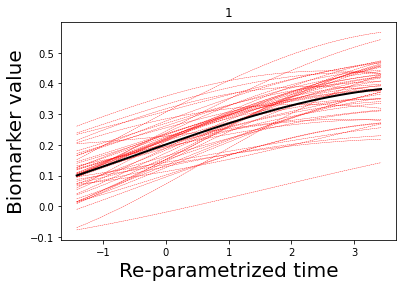

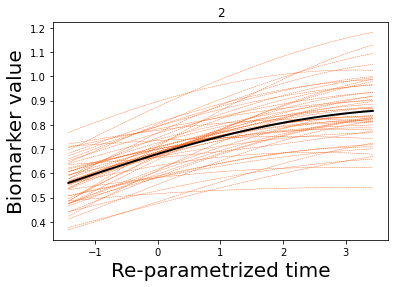

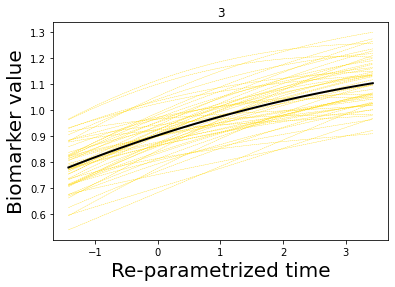

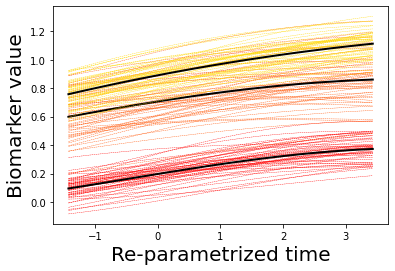

[7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7]
[5, 6, 7, 8, 9, 10, 11, 12]


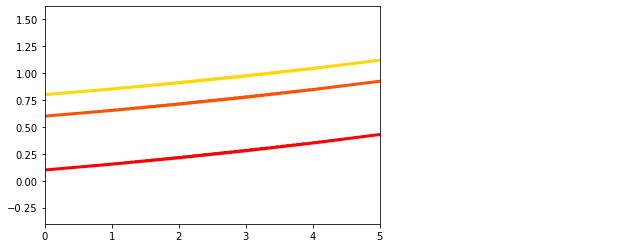

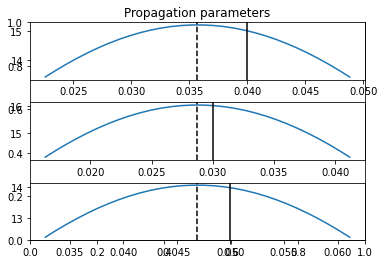

In [ ]:
### Let's now plot some results

## Here we plot the estimated GPs
model.Plot_GPs(subject = False, just_subplot = False, save_fig = False)

# and compare with the simulated data
plt.figure()
dg.plot(mode=1, save_fig = False)


## Plot the estimated propagation parameters and compare with ground truth values
model.Plot_kij(save_fig=False, synthetic = theta)

## Part IV: application to amyloid spread on ADNI data

Of course we can way more, plot-wise! 

Let's have a look at it, but on real ADNI /amyloid data, so that we can gather some biological insights.

Specifically:

- we use the **ACP** model (which is the most complete, accounts for the processes of accumulation, clearance, propagation etc);
- the substrate along which propagation occurs is the **structural connectome** derived from diffusion MRI data;
- we analyze **AV45--PET** brain imaging data of 770 subjects from **ADNI**, with a total of 1477 longitudinal data points.


### The data

The model is pre-trained so now we play on data visualisation.

Quick info on the data we used
![Table](https://github.com/Disease-Progression-Modelling/disease-progression-modelling.github.io/blob/master/_static/img/gppm/notebook-figs/table.png?raw=true)



## Set up

In [ ]:
import GP_progression_model

import sys

from sys import platform as sys_pf
from GP_progression_model import DataGenerator
import numpy as np
import torch
import matplotlib
if sys_pf == 'darwin':
    matplotlib.use("TkAgg")

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from numpy import genfromtxt
import pandas as pd
import requests

sys.path.append('../../')
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load pre-trained data

dat = 'http://sgarbarino.github.io/tutorial/ADNI_processed.dat'
r = requests.get(dat)
open('data.dat', 'wb').write(r.content)

data = torch.load('data.dat')

model = data[0] 

## Visualisation

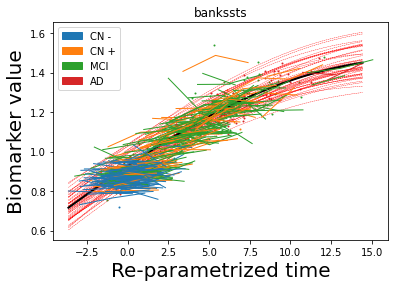

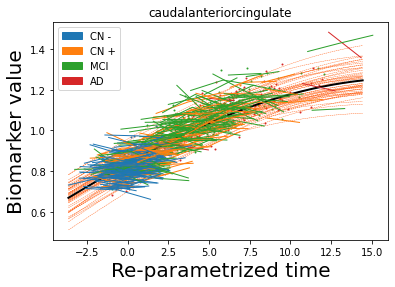

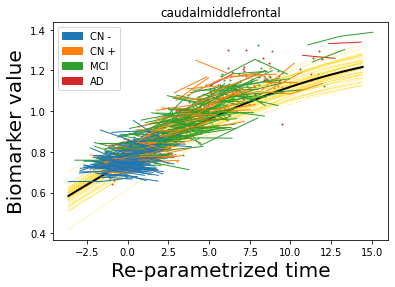

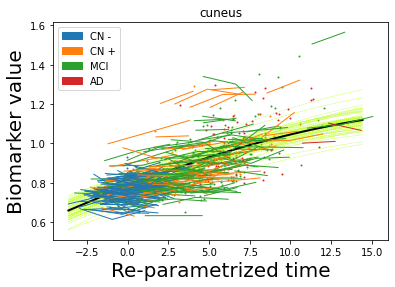

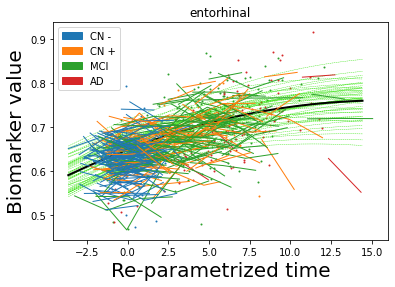

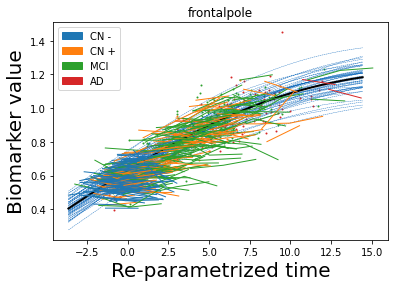

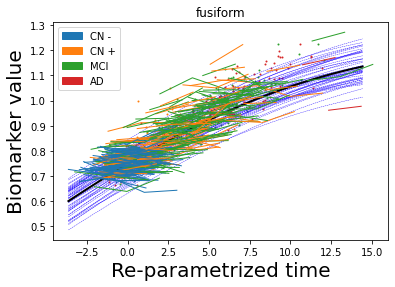

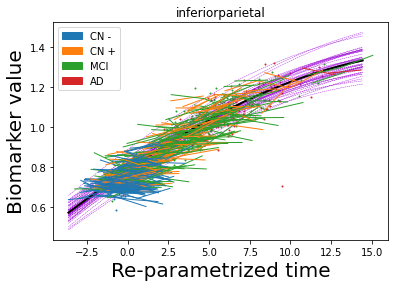

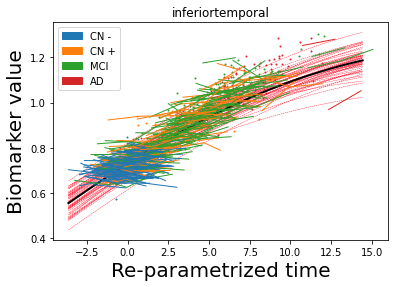

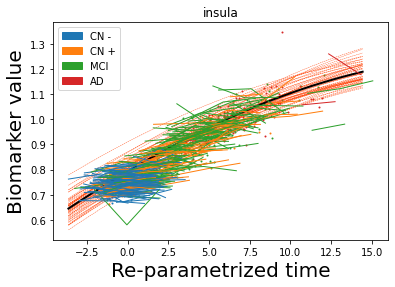

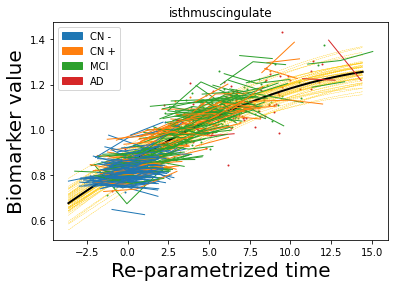

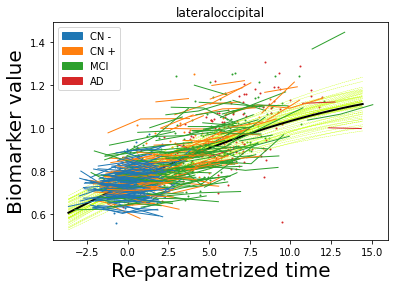

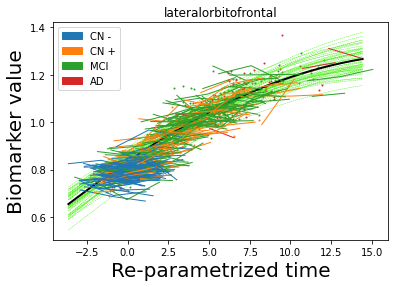

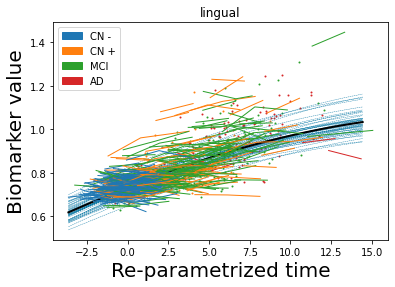

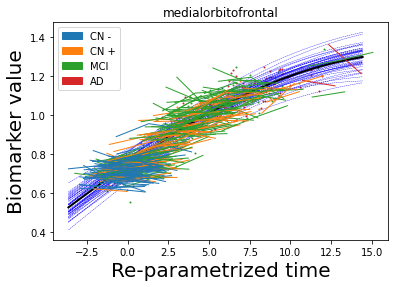

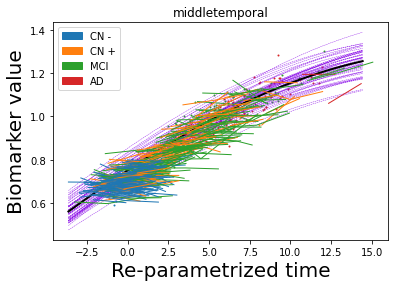

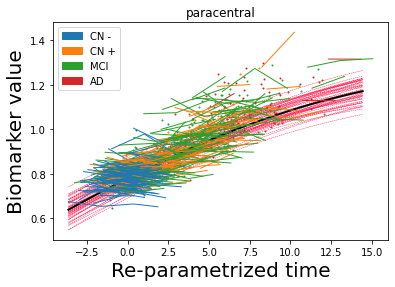

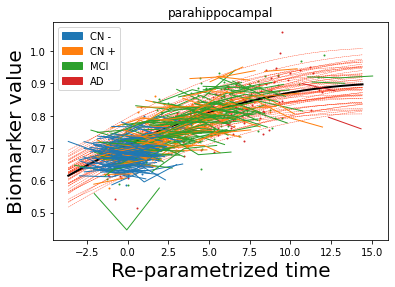

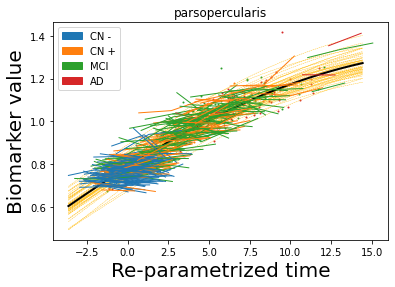

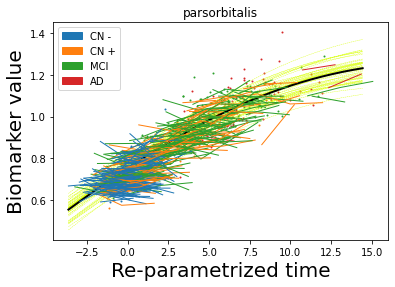

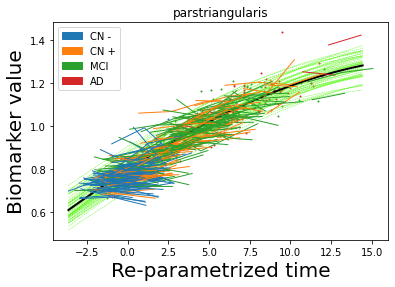

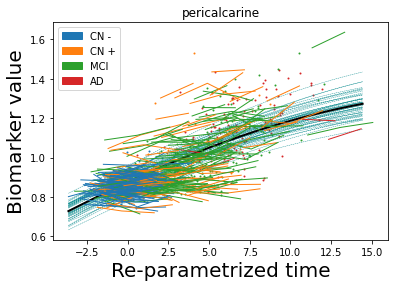

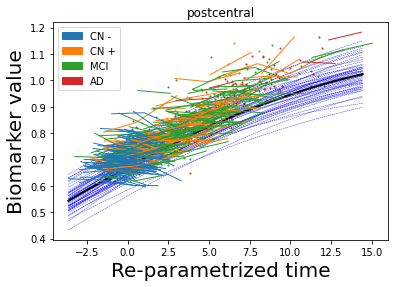

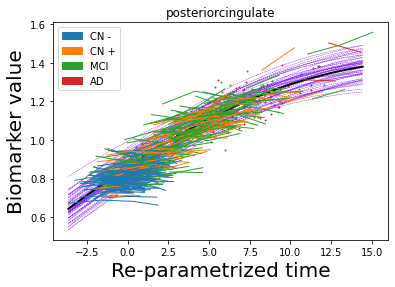

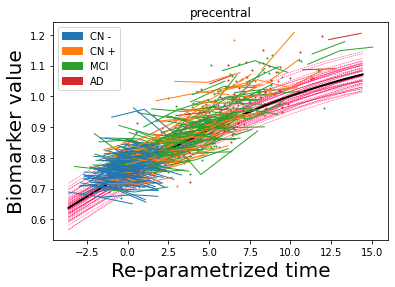

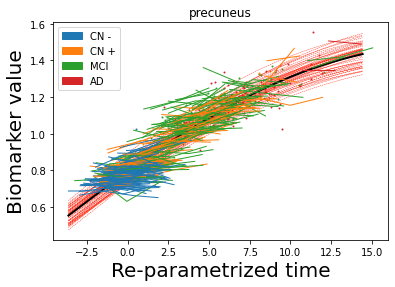

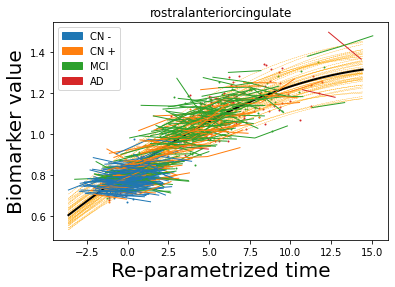

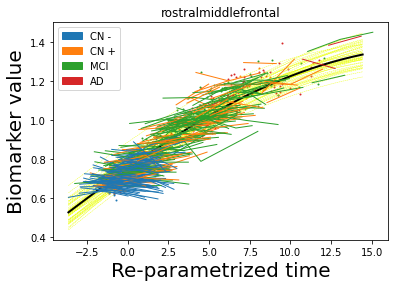

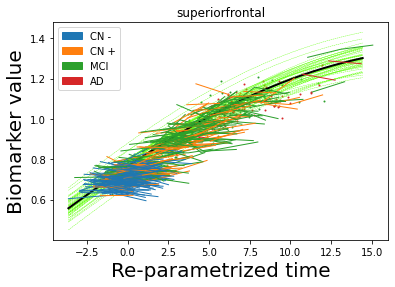

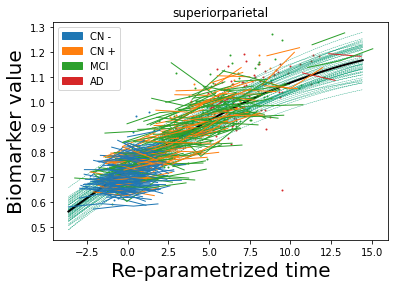

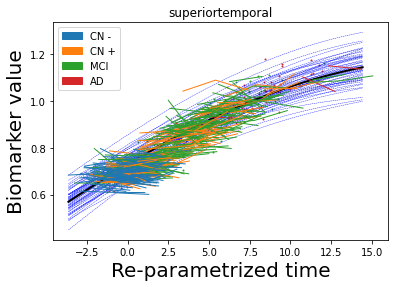

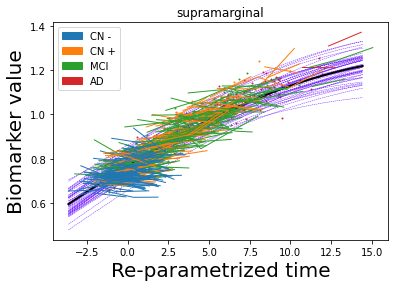

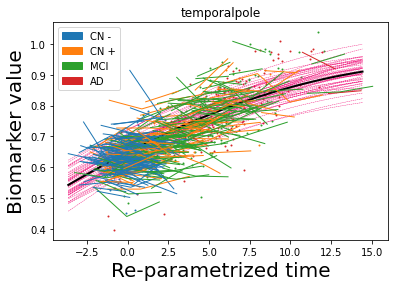

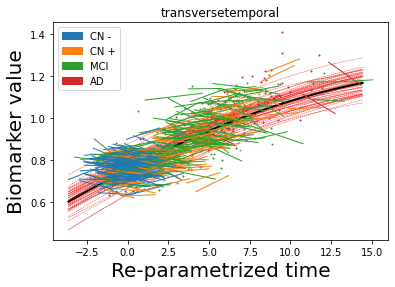

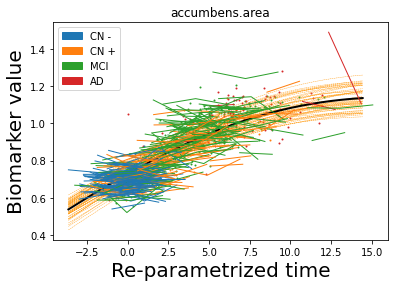

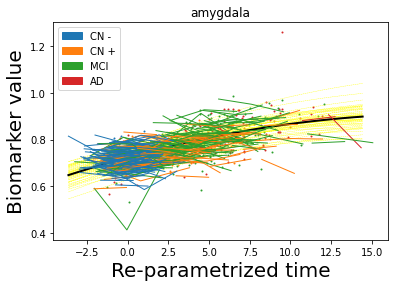

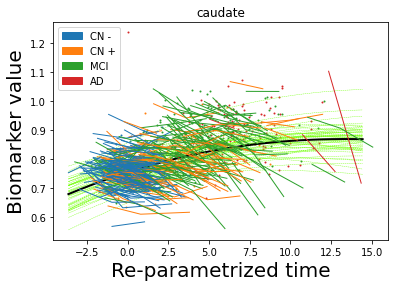

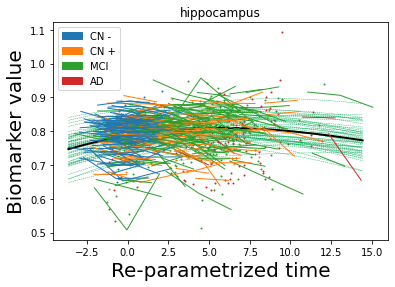

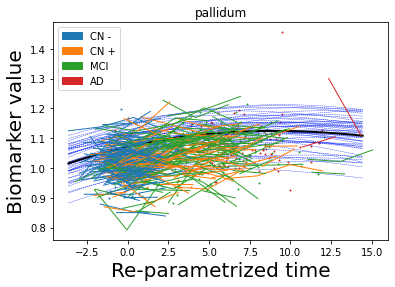

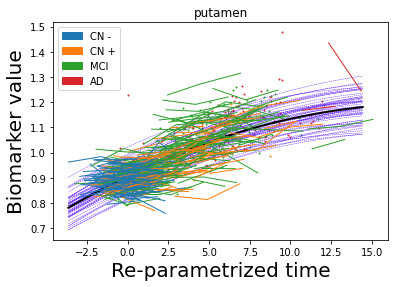

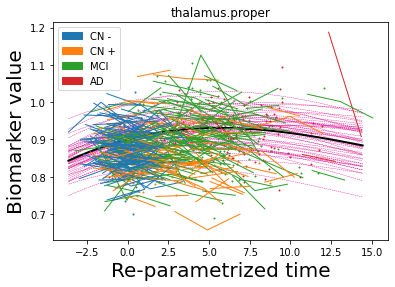

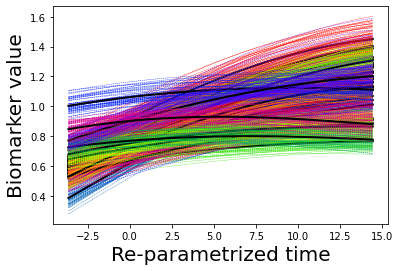

In [ ]:
## Plot estimated biomarker trajectories together with subjects, which have been shifted according to the time reparametrization 
model.Plot_GPs(subject = True,  save_fig = False) 

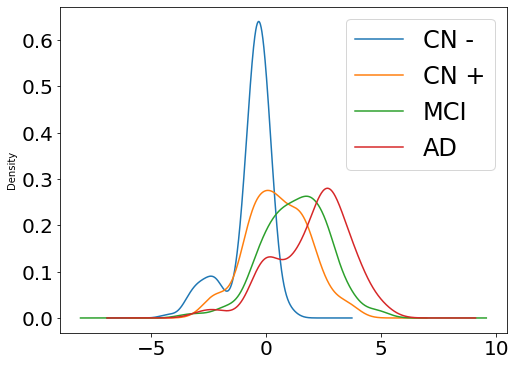

In [ ]:
## Plot diagnostic separation of subjects according to time-shift
time = model.Return_time_parameters()
list_biomarker = data[2]
group = data[3]
df = pd.DataFrame({"class": group, "vals": time})
fig, ax = plt.subplots(figsize=(8, 6))
for label, df in df.groupby('class'):
    df.vals.plot(kind="kde", ax=ax, label=model.group_name[label], fontsize=12)
plt.legend(fontsize=24)
plt.tick_params(labelsize=20)
plt.show()

In [ ]:
## Visualise propagation parameters along the connections over time, on three specific regions of interest
x_range = data[5]
x_mean_std = data[6]
mean_norm = data[8]
coordinates = data[10]
gamma = data[11]
eta = data[12]
kij = data[13]

idx_biom_selected = [25, 31, 13] # ---> Lingual, precuneus, supramarginal

### We have two ways of visualising:

#### A) Along the associated anatomical connections
#### B) Overlaid on the binary adjacency matrix of the connectome (nilearn is needed)

!pip install nilearn
GP_progression_model.plot_glass_brain(kij, gamma, eta, coordinates, idx_biom_selected, list_biomarker, model.connectome, x_range, mean_norm, './')


     |████████████████████████████████| 3.1MB 8.3MB/s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

We have generated A) and B) (look at the Files folder on the left tab here).

From there we can easily generate animated videos!

| trajectories of the three regions | propagation along the connections| propagation along the connectomne|
|:-----------------------------:|:-----------------------------:|:-----------------------------:|
|![GPs](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/GPs.gif?raw=true "GPss")| ![kijs](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/kijs.gif?raw=true "kijs")| ![connectome](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/connectome.gif?raw=true "connectome") |









### Personalisation of disease dynamics

For each subject, the DS structure of of framework allows to integrate the dynamics over time given an initial condition, obtaining a vector field governing forward and backward evolution in time associated with the individuals. 

#### We can derive two animated plots:

A) Streamlines for the estimated amyloid deposition dynamics

B) Predicted cumulative amyloid deposition on the brain






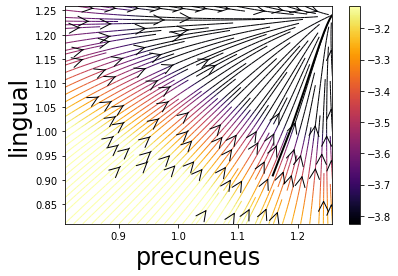

In [ ]:
## As didactic purpose we just generate example vector field plot

Y = data[9]
theta = model.Return_ODE_parameters()

sub = 93 # select a specific subject (this is MCI converted to AD within our time-frame)

region1 = 25 # select two regions of interest: here precuneus and lingual
region2 = 13

idx = np.array([region1, region2])
idx_compl = np.setxor1d(range(len(list_biomarker)), idx)

x0_full = np.array([Y[i][sub][0] for i in range(len(list_biomarker))]) # subject-specific baseline values
t = (x_range.data.numpy() * model.x_mean_std[0][1] + model.x_mean_std[0][0]).squeeze() # subject-specific time frame

GP_progression_model.plot_vector_field(idx, list_biomarker, theta, x0_full[idx], 100, x0_full[idx_compl], t = t,
                                       xran = [x0_full[idx].min() - .1, x0_full[idx].max() + .1], 
                                       save_fig = False, plot = 'streamline', propagation_model = model.propagation_model,
                                       subject = True, std = False)


These plots require more sophisticated tools (e.g. Brain images for B) obtained with BrainPainter - available at brainpainter.csail.mit.edu/) - see you at a next tutorial session for learning about it :)

| Streamlines for the estimated amyloid deposition dynamics |
|:-----------------------------:|
|![VFs](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/VFs.gif?raw=true "VFs")|



| Predicted cumulative amyloid deposition (cortical)| Predicted cumulative amyloid deposition (cortical)| Predicted cumulative amyloid deposition (subcortical)|
|:-----------------------------:|:-----------------------------:|:-----------------------------:|
|![outer](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/93_cortical_outer.gif?raw=true "outer")| ![inner](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/93_cortical_inner.gif?raw=true "inner")| ![sub](https://github.com/sgarbarino/sgarbarino.github.io/blob/master/images/gif/93_subcortical.gif?raw=true "subcortical") |